In [1]:
import heeps

### 1. Create a config dictionary with your simulation parameters in read_config

In [2]:
conf = dict(
    dir_current = '$HOME/heeps_metis',  # specify a directory
    f_phase = 'wavefront/COMPASS_201810_RandomWind_100screens_meters.fits',
    nframes = 10,                       # number of SCAO phase screens selected
    cpu_count = 10,                     # number of physical CPUs
)
conf = heeps.config.read_config(verbose=False, **conf)

### 2. Update config parameters. The following parameters will be updated to match the selected spectral band:
lam, pscale, flux_star, flux_bckg, npupil, beam_ratio, ndet, hfov, hfov_lamD

In [3]:
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf) 

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=285, pscale=5.4700 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)



### 3. Load entrance pupil, and create 'wavefront' object

In [4]:
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


### 4.  Create an off-axis PSF template for injecting fake exoplanets

In [5]:
heeps.wavefront.propagate(wf, onaxis=False, avg=True, savefits=True, verbose=True, **conf);

Off-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'COMPASS_201810_RandomWind_100screens_meters.fits'
   nscreens=10 (nframes=10, nstep=1)
Create off-axis PSF cube
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.04, 0.0249], ls_misalign=None
   2022-06-22 15:35:25, e2e simulation using 10 cores
   2022-06-22 15:35:29, completed in 3.9 seconds
Average PSF cube



### 5. Create a cube of on-axis PSFs (=star)

In [6]:
heeps.wavefront.propagate(wf, onaxis=True, savefits=True, verbose=True, **conf);

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'COMPASS_201810_RandomWind_100screens_meters.fits'
   nscreens=10 (nframes=10, nstep=1)
Create on-axis PSF cube
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.04, 0.0249], ls_misalign=None
   2022-06-22 15:35:31, e2e simulation using 10 cores
   2022-06-22 15:35:37, completed in 6.26 seconds



### 6. Produce a 5-sigma sensitivity (contrast) curve

In [7]:
sep1, sen1 = heeps.contrast.adi_one(savepsf=True, savefits=True, verbose=True, **conf)

Apply ADI technique: add_bckg=False
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=RAVC, band=L
   ncube=10, ndet=403
   pscale=5.47 mas, dit=0.3 s
   loading Vortex off-axis transmission
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-06-22 15:35:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.303554003035229, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:05.730034
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### 7.  Add star flux + background flux + photon noise


In [8]:
conf['add_bckg'] = True
sep2, sen2 = heeps.contrast.adi_one(savepsf=True, savefits=True, verbose=True, **conf)

Apply ADI technique: add_bckg=True
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=RAVC, band=L
   ncube=10, ndet=403
   pscale=5.47 mas, dit=0.3 s
   offaxis_trans=0.3636, mask_trans=0.8532,
   mag=5, dit=0.300
   star_signal=2.70e+08, bckg_noise=8.26e+03
   loading Vortex off-axis transmission
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-06-22 15:35:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.3035540140641206, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:05.701757
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### 8. Create a figure 

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

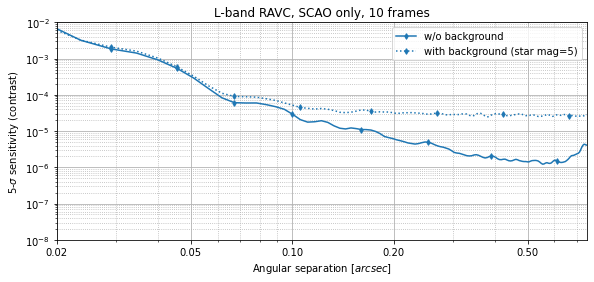

In [10]:
savename = 'ADI_contrast_curve.png'
plt.figure(figsize=(9.5, 4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
plt.title('%s-band %s, SCAO only, %s frames'%(conf['band'], conf['mode'], conf['nframes']))
plt.plot(sep1, sen1, 'C0', label='w/o background', marker='d', markevery=0.12, markersize=4)
plt.plot(sep2, sen2, 'C0:', label='with background (star mag=5)', marker='d', markevery=0.12, markersize=4)
plt.legend()
plt.xlim(0.02, 0.75)
plt.ylim(1e-8,1e-2)
plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
plt.savefig('%s/%s'%(conf['dir_output'], savename), dpi=300, transparent=True);